In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm.auto import tqdm

import multitask.dataset as dataset
import multitask.models.task_switching.hooks as hooks
from multitask.models.task_switching import get_task_model
from multitask.representations import get_mean_activations, calculate_rdm, plot_rdm
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
path_data = os.path.join('..', '..', 'data')
path_figure = os.path.join('svg', 'figureS19_sm_empirical_task_switching_letters.svg')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')


In [3]:
num_runs = 10
initial_seed = 1234
max_seed = 10e5
num_epochs = 50
num_hidden = 10 * [100]
batch_size = 100
num_train = 41080
num_test = 8216
tasks_names = ['vowel', 'position']
idxs_contexts = list(range(len(num_hidden)))

In [4]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2024-01-12_18-56-09)


In [5]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [6]:
seeds = sorted(list(results_task_switching.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[165158, 220532, 318129, 451283, 486191, 514041, 818831, 869016, 908341, 978124]
['vowel', 'position']


In [7]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 1

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

vowel: [1, 0]
position: [0, 1]


## Plot All RDMs

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

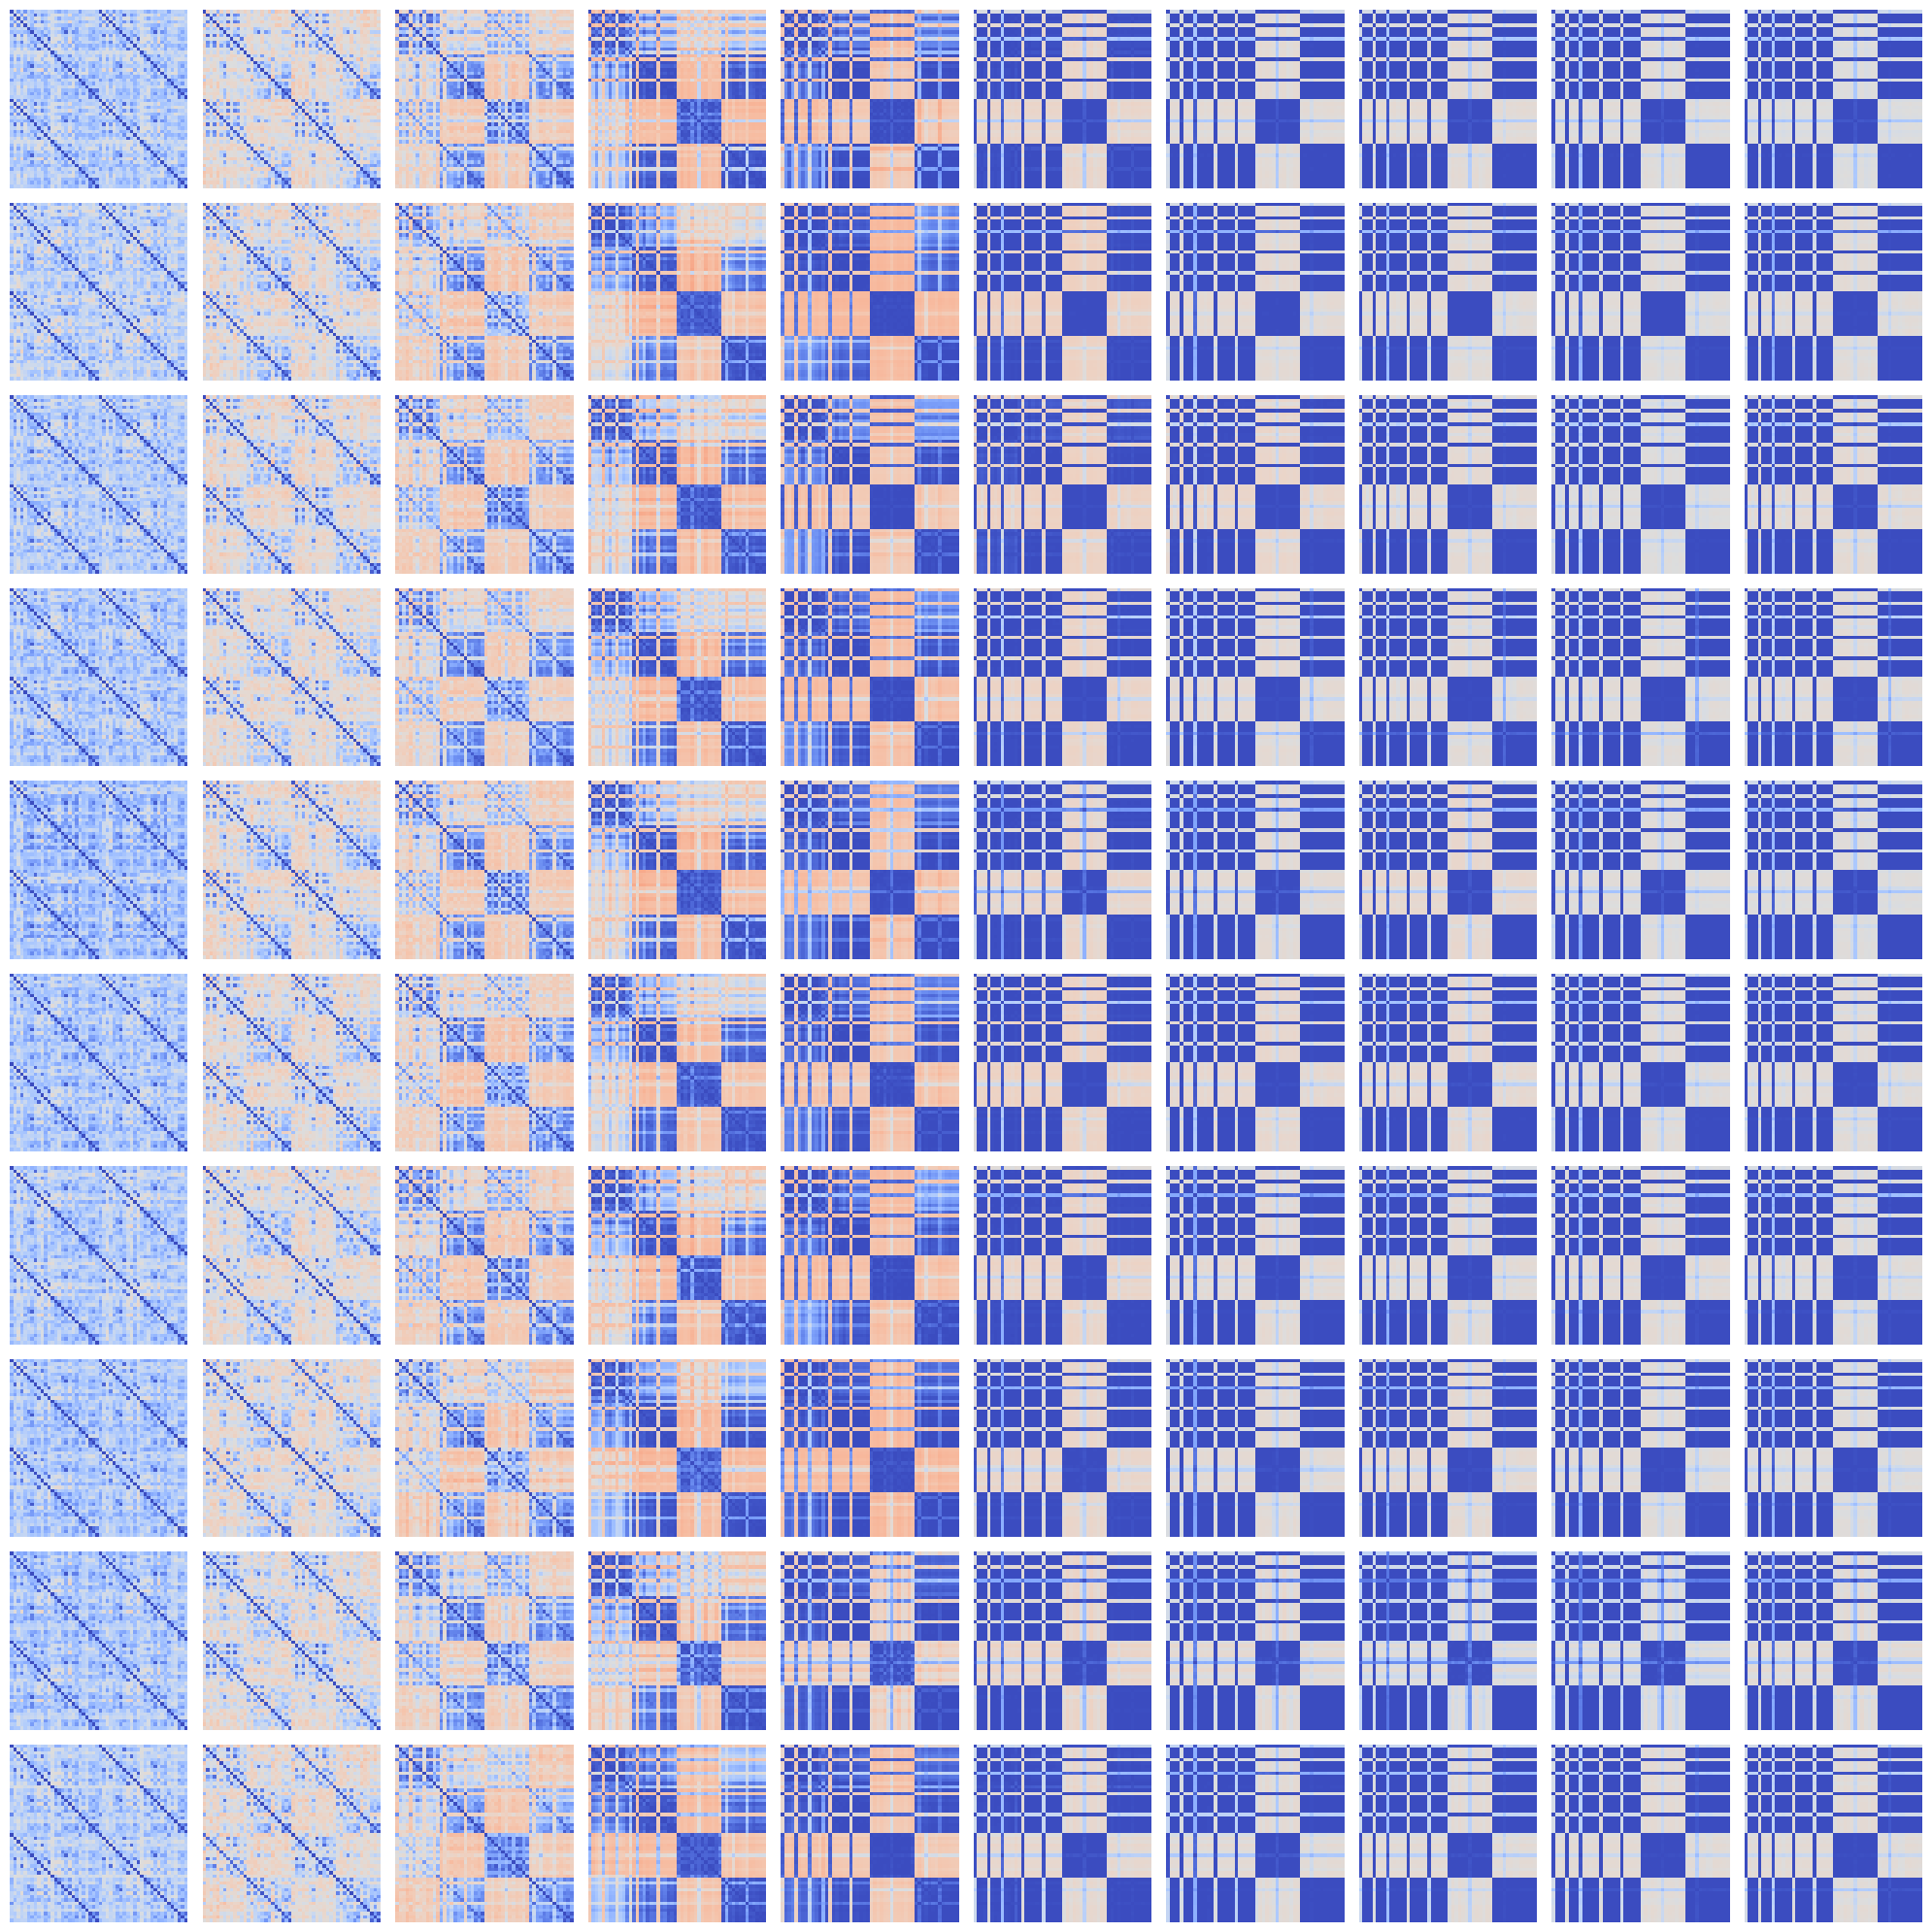

In [8]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)
list_rdm = []

fig, ax = plt.subplots(num_runs, num_layers, figsize=(2 * num_layers, 2 * num_runs))

for i_seed, seed in tqdm(enumerate(seeds), total=num_runs):
    state_dict = results_task_switching[seed]['model']
    model = get_task_model(task_switching_tasks,
                           num_hidden,
                           idxs_contexts,
                           device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    letters = test_dataloaders[tasks_names[0]].dataset.letters.numpy()
    letters = letters[indices['test']]

    _, activations = hooks.get_layer_activations(model,
                                                tasks_testloader,
                                                criterion,
                                                device=device,
                                                disable=True)

    mean_activations = get_mean_activations(activations,
                                            num_hidden,
                                            list_labels=letters,
                                            tasks_names=tasks_names)

    rdm_dict = calculate_rdm(mean_activations,
                             tasks_names=tasks_names)
    list_rdm.append(rdm_dict)

    plot_rdm(ax[i_seed], rdm_dict, num_hidden, cmap='coolwarm', vmin=0, vmax=2)

fig.tight_layout()
plt.show()

## Average RDM

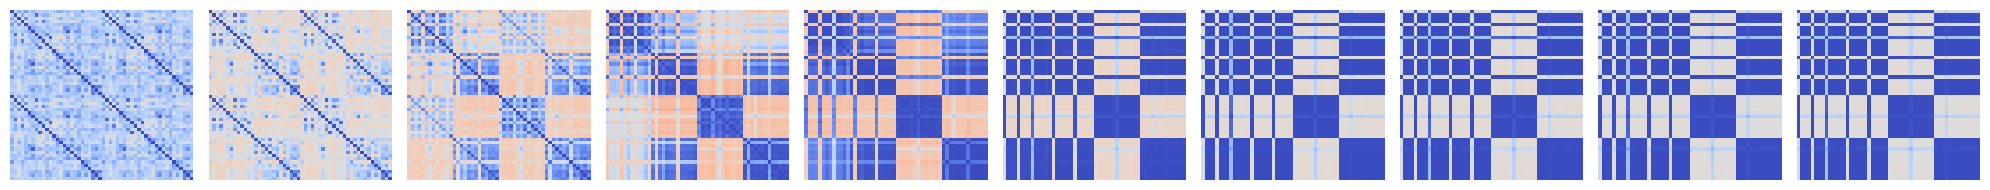

In [9]:
mean_rdm = {}

for layer in range(num_layers):
    mean_rdm[layer+1] = np.zeros_like(list_rdm[0][layer+1])
    for rdm in list_rdm:
        mean_rdm[layer+1] += rdm[layer+1]
    mean_rdm[layer+1] /= num_runs

fig, ax = plt.subplots(1, num_layers, figsize=(2 * num_layers, 2))
plot_rdm(ax, mean_rdm, num_hidden, cmap='coolwarm', vmin=0, vmax=2)
fig.tight_layout()
fig.savefig(path_figure)
plt.show()

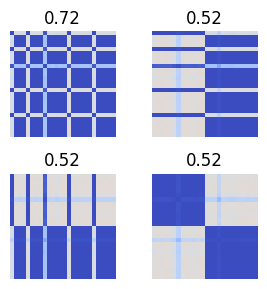

In [10]:
num_tasks = 2
num_digits = 26

fig, ax = plt.subplots(num_tasks, num_tasks, figsize=(3, 3))

for i_task in range(num_tasks):
    for j_task in range(num_tasks):
        rows = slice(i_task * num_digits, (i_task + 1) * num_digits)
        cols = slice(j_task * num_digits, (j_task + 1) * num_digits)

        rdm = mean_rdm[10][rows, cols]
        R = 1 - mean_rdm[10][rows, cols]
        sr = np.abs(R).mean()

        ax[i_task, j_task].imshow(rdm, cmap='coolwarm', vmin=0, vmax=2)
        ax[i_task, j_task].set_title(f'{sr:.2f}')
        ax[i_task, j_task].axis('off')

fig.tight_layout()
fig.savefig(path_figure)
plt.show()